In [1]:
import numpy as np
import scipy.optimize
import corner
import emcee

import matplotlib.pyplot as plt

Make general plotting and analysis functions that we can apply to different combinations of data, likelihoods, models, etc.

In [5]:
def plot_data(x, y, y_err, models=None):
    fig, ax = plt.subplots()

    ax.errorbar(x, y, y_err, fmt=".", label="Data")

    if models is not None:
        for model_def in models:
            if "lower" in model_def:
                ax.fill_between(
                    model_def["x"], model_def["lower"], model_def["upper"],
                    **model_def.get("style", {})
                )
            else:
                ax.plot(
                    model_def["x"], model_def["y"],
                    **model_def.get("style", {})
                )

    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.legend(frameon=False)

    return fig, ax


def analyse_data(data,
                 log_posterior_fn, model_fn, predict_fn,
                 param_names, theta_true):

    x, y, sigma_y = data["x"], data["y"], data["y_err"]

    theta_init = theta_true

    true_model_plot_def = dict(
        x=x, y=model_fn(*theta_true, x),
        style=dict(color="black", ls="--", label="True model")
    )

    # Find the MAP
    def negative_log_posterior(theta, x, sigma_y, y):
        return -log_posterior_fn(*theta, x, sigma_y, y)
    
    MAP_result = scipy.optimize.minimize(
        fun=negative_log_posterior,
        x0=theta_init,
        args=(x, sigma_y, y)
    )
    theta_MAP = MAP_result.x

    print("MAP results")
    for name, theta in zip(param_names, theta_MAP):
        print(f"{name}_MAP = {theta}")
    
    plot_data(
        x=x, y=y, y_err=sigma_y,
        models=[
            true_model_plot_def,
            dict(x=x, y=model_fn(*theta_MAP, x),
                 style=dict(color="C1", label="MAP model")),
        ]
    )

    # Sample posterior with emcee

    # emcee passes an array of values for the sampled parameters
    # This wrapper just splits the array theta into m and b
    def log_posterior_wrapper(theta, x, sigma_y, y):
        return log_posterior_fn(*theta, x, sigma_y, y)

    # emcee requires some extra settings to run
    n_param = len(theta_true) # Number of parameter we are sampling
    n_walker = 10             # Number of walkers. This just needs to be larger than 2*n_param + 1
    n_step = 5000             # How many steps each walker will take. The number of samples will be n_walker*n_step

    # The starting point for each walker
    theta_init = theta_init + 0.1*np.random.normal(size=(n_walker, n_param))

    sampler = emcee.EnsembleSampler(
        nwalkers=n_walker, ndim=n_param,
        log_prob_fn=log_posterior_wrapper,
        args=(x, sigma_y, y)
    )
    state = sampler.run_mcmc(theta_init, nsteps=n_step, progress=True)

    # The samples will be correlated, this checks how correlated they are
    # We will discuss this once we come to MCMC methods
    print("Auto-correlation time of chain:")
    for name, value in zip(param_names, sampler.get_autocorr_time()):
        print(f"{name} = {value:.1f}")

    max_autocorr_time = max(sampler.get_autocorr_time())

    # We need to discard the beginning of the chain (a few auto-correlation times)
    # to get rid of the initial conditions
    chain = sampler.get_chain(
        discard=int(5*max_autocorr_time),
        thin=int(max_autocorr_time/2),
        flat=True
    )

    # Make a corner plot
    fig = plt.figure()
    fig = corner.corner(
        chain,
        bins=40,
        labels=param_names,
        truths=theta_true,
        levels=1-np.exp(-0.5*np.array([1, 2])**2), # Credible contours corresponding to 1 and 2 sigma in 2D
        quantiles=[0.025, 0.16, 0.84, 0.975],
        fig=fig
    )

    print("Posterior results (mean±std)")
    for i, name in enumerate(param_names):
        print(f"{name} = {np.mean(chain[:,i]):.2f}±{np.std(chain[:,i]):.2f}")

    # Make predictive distributions
    # Choose a small subsample of the chain for plotting purposes
    chain_samples = chain[np.random.choice(chain.shape[0], size=200)]
    # Evaluate the model at the sample parameters
    model_predictive = np.array(
        [model_fn(*sample, x) for sample in chain_samples]
    )
    model_quantiles = np.quantile(
        model_predictive, q=[0.025, 0.16, 0.84, 0.975], axis=0
    )

    posterior_predictive = np.array(
        [predict_fn(*sample, x, sigma_y) for sample in chain_samples]
    )
    posterior_predictive_quantiles = np.quantile(
        posterior_predictive, q=[0.025, 0.16, 0.84, 0.975], axis=0
    )

    plot_data(
        x=x, y=y, y_err=sigma_y,
        models=[
            true_model_plot_def,
            dict(x=x, y=model_fn(*theta_MAP, x),
                 style=dict(color="C1", label="MAP model")),
            
            dict(x=x, lower=model_quantiles[0], upper=model_quantiles[-1],
                 style=dict(color="C1", alpha=0.5, label="Model predictions")),
            dict(x=x, lower=model_quantiles[1], upper=model_quantiles[-2],
                 style=dict(color="C1", alpha=0.5)),

            dict(x=x, lower=posterior_predictive_quantiles[0], upper=posterior_predictive_quantiles[-1],
                 style=dict(color="grey", alpha=0.5, label="Posterior predictions")),
            dict(x=x, lower=posterior_predictive_quantiles[1], upper=posterior_predictive_quantiles[-2],
                 style=dict(color="grey", alpha=0.5)),
        ]
    )

We can now use the same `analyse_data` function on different data sets, likelihoods, models, priors, etc.

Let us start with the first example in `lessons/data/linear_fits/data_0.txt`:

In [2]:
m_true = 1.3
b_true = -0.2

x, y, y_err = np.loadtxt("../lessons/data/linear_fits/data_0.txt", unpack=True)
# For now, all error are the same
sigma_y = y_err[0]

Define our model, likelihood, prior, and posterior.

In [3]:
def model(m, b, x):
    return m*x + b

# We use the logarithm here for computational reasons
def log_likelihood(y, m, b, x, sigma_y):
    prediction = model(m, b, x)

    n = len(y)
    return (
        -0.5 * np.sum((y - prediction)**2/sigma_y**2)      # Exponent
        - n/2*np.log(2*np.pi*sigma_y**2)                   # Normalisation
    )

def log_prior(m, b):
    mu_m = -1
    mu_b = 1

    sigma_m = 1
    sigma_b = 1.2

    return (
        -0.5*(m-mu_m)**2/sigma_m**2      # m exponent
        -0.5*(b-mu_b)**2/sigma_b**2      # b exponent
        - 0.5*np.log(2*np.pi*sigma_m**2) # Normalisation
        - 0.5*np.log(2*np.pi*sigma_b**2) # Normalisation
    )

def log_posterior(m, b, x, sigma_y, y):
    return log_likelihood(y, m, b, x, sigma_y) + log_prior(m, b)

# Predict new data, given parameters
def predict(m, b, x, sigma_y):
    mu = model(m, b, x)
    return np.random.normal(loc=mu, scale=sigma_y)


Now we analyse the data.

MAP results
m_MAP = 1.2211022384719732
b_MAP = -0.11088757118016776


100%|██████████| 5000/5000 [00:01<00:00, 4552.06it/s]


Auto-correlation time of chain:
m = 33.1
b = 33.8
Posterior results (mean±std)
m = 1.22±0.10
b = -0.11±0.13


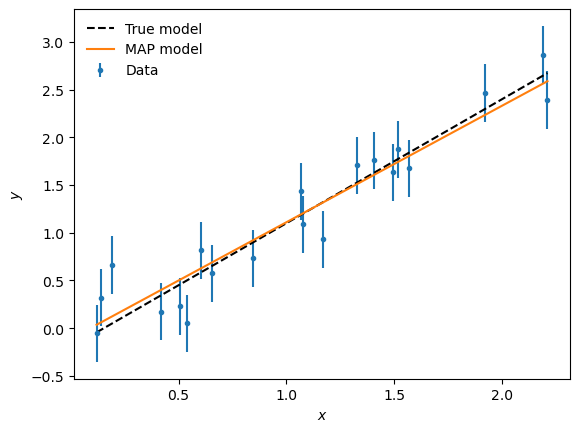

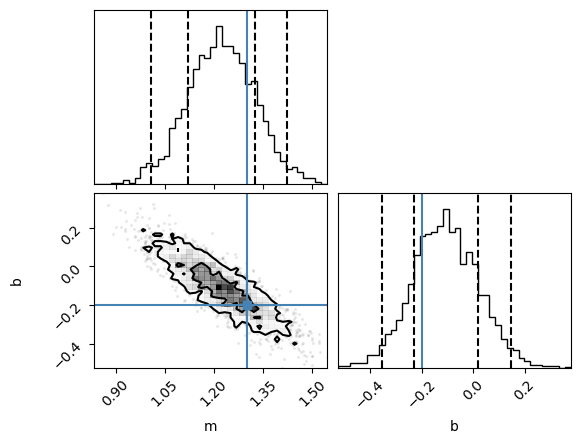

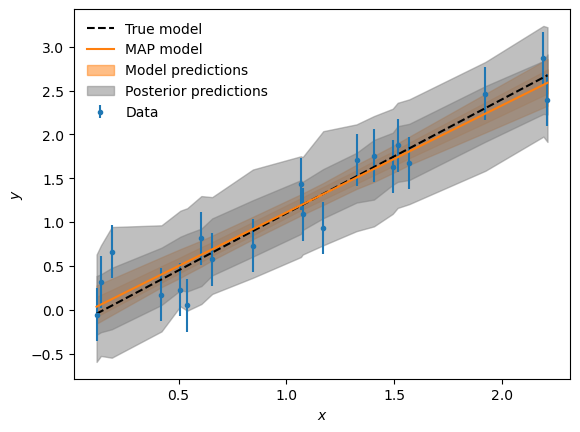

In [7]:
analyse_data(
    data=dict(x=x, y=y, y_err=sigma_y),
    log_posterior_fn=log_posterior,
    model_fn=model,
    predict_fn=predict,
    param_names=["m", "b"],
    theta_true=[m_true, b_true],
)

Let us move on to the other data set in `lessons/data/linear_fits/data_1.txt`.

In [8]:
# Load the data
x, y, y_err = np.loadtxt("../lessons/data/linear_fits/data_1.txt", unpack=True)

m_true, b_true = -0.7, 1.2
f_true = 0.51

MAP results
m_MAP = -0.3614544936159469
b_MAP = 0.6994697875874143


100%|██████████| 5000/5000 [00:01<00:00, 3928.86it/s]


Auto-correlation time of chain:
m = 36.0
b = 36.0
Posterior results (mean±std)
m = -0.36±0.04
b = 0.70±0.05


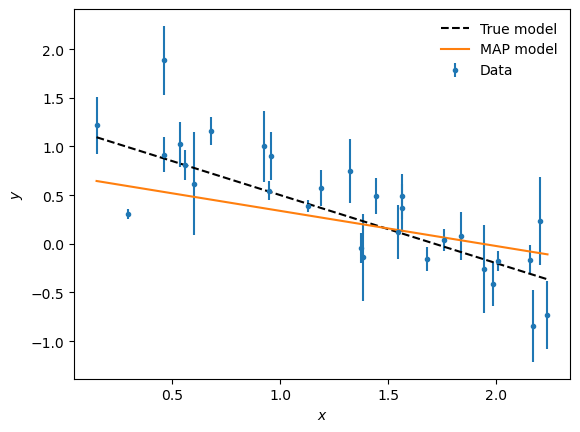

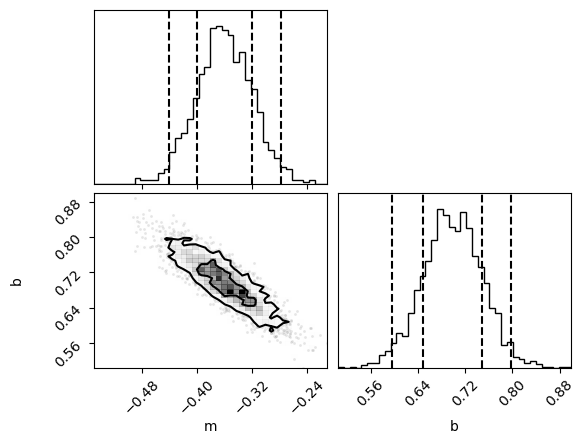

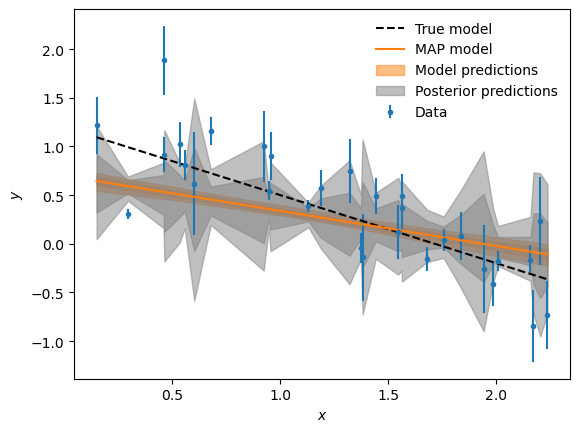

In [11]:
# Because the error is now different for each data point, we need to adapt the
# likelihood a bit
def log_likelihood_heteroscedastic(y, m, b, x, sigma_y):
    prediction = model(m, b, x)

    return (
        -0.5 * np.sum((y - prediction)**2/sigma_y**2)    # Exponent
        -0.5 * np.sum(np.log(2*np.pi*sigma_y**2))        # Normalisation
    )

def log_posterior_heteroscedastic(m, b, x, sigma_y, y):
    return log_likelihood_heteroscedastic(y, m, b, x, sigma_y) + log_prior(m, b)

analyse_data(
    data=dict(x=x, y=y, y_err=y_err),
    log_posterior_fn=log_posterior_heteroscedastic,
    model_fn=model,
    predict_fn=predict,
    param_names=["m", "b"],
    theta_true=[m_true, b_true],
)

Finally, try with the correct likelihood.

MAP results
m_MAP = -0.7355425584965917
b_MAP = 1.2885817199053355
f_MAP = 0.29532331062475015


100%|██████████| 5000/5000 [00:01<00:00, 3809.53it/s]


Auto-correlation time of chain:
m = 46.3
b = 46.4
f = 44.1
Posterior results (mean±std)
m = -0.73±0.10
b = 1.27±0.16
f = 0.40±0.17


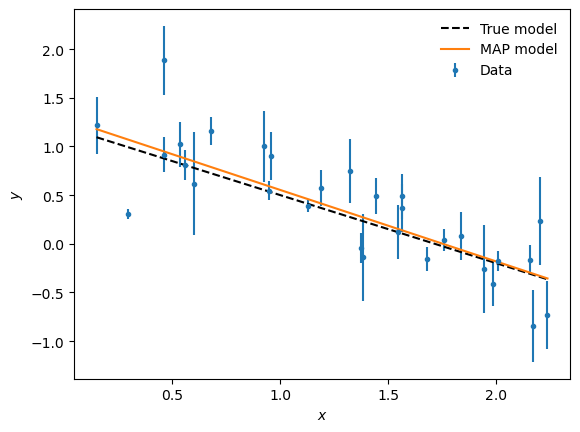

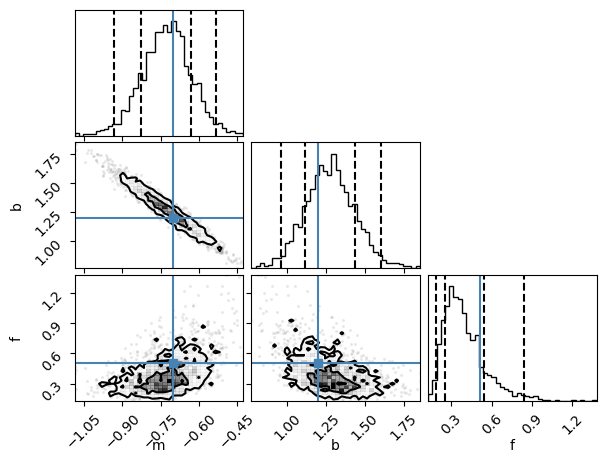

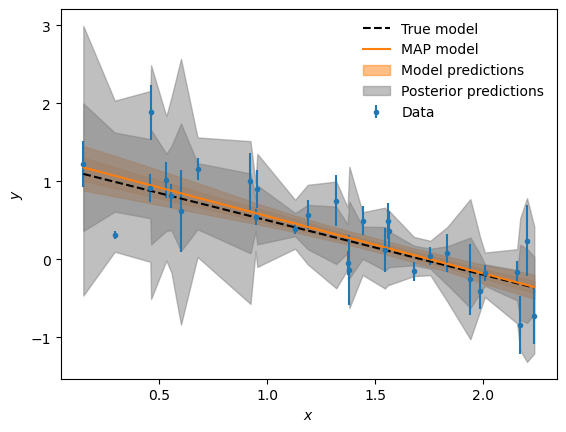

In [12]:
def log_likelihood_true(y, m, b, f, x, sigma_y):
    prediction = model(m, b, x)

    sigma = sigma_y + f*prediction**2
    n = len(y)
    return (
        -0.5 * np.sum((y - prediction)**2/sigma**2)   # Exponent
        -0.5 * np.sum(np.log(2*np.pi*sigma**2))       # Normalisation
    )

def log_prior_true(m, b, f):
    mu_f = 0.5
    sigma_f = 1

    return log_prior(m, b) - 0.5*(f - mu_f)**2/sigma_f**2

def log_posterior_true(m, b, f, x, sigma_y, y):
    return log_likelihood_true(y, m, b, f, x, sigma_y) + log_prior_true(m, b, f)

def predict_true(m, b, f, x, sigma_y):
    mu = model(m, b, x)
    sigma = sigma_y + f*mu**2
    return np.random.normal(loc=mu, scale=sigma)

f_true = 0.51

analyse_data(
    data=dict(x=x, y=y, y_err=y_err),
    log_posterior_fn=log_posterior_true,
    model_fn=lambda m, b, f, x: model(m, b, x),
    predict_fn=predict_true,
    param_names=["m", "b", "f"],
    theta_true=[m_true, b_true, f_true],
)
